In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import splitfolders 
import cv2
import matplotlib.pyplot as plt

2023-06-08 13:58:09.578809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 13:58:10.748754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vasu/miniconda3/envs/tf/lib/:/home/vasu/miniconda3/envs/tf/lib/
2023-06-08 13:58:10.754513: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vasu/miniconda3/envs/tf/lib/:/home/vasu/miniconda3/e

In [3]:
# Shape of the image
img = cv2.imread(r"dataset/train/Bengin cases/Bengin case (1).jpg")
print(img.shape)

(512, 512, 3)


In [4]:
# Split folders
# splitfolders.ratio(r'dataset', output="output", seed=1337, ratio=(0.8, 0.2))

Copying files: 1097 files [01:30, 12.13 files/s]


In [4]:
# Directories
train_dir = r'dataset/train'
test_dir =r'dataset/val'

In [5]:
num_classes = 3
input_shape = (512, 512, 1)

# Data augmentation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, labels="inferred", label_mode="categorical", class_names=None, color_mode="rgb", batch_size=32, image_size=(512, 512), shuffle=True, seed=1337, validation_split=None, subset=None, interpolation="bilinear", follow_links=False, smart_resize=False)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, labels="inferred", label_mode="categorical", class_names=None, color_mode="rgb", batch_size=32, image_size=(512, 512), shuffle=True, seed=1337, validation_split=None, subset=None, interpolation="bilinear", follow_links=False, smart_resize=False)

Found 876 files belonging to 3 classes.


2023-06-08 13:58:21.507116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 13:58:21.555291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 13:58:21.555399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 13:58:21.556729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Found 221 files belonging to 3 classes.


In [6]:
# Split the data into train and test
x_train, y_train = next(iter(train_ds))
x_test, y_test = next(iter(test_ds))

# Print the shape of the data
print("Shape of the X train: ", x_train.shape)
print("Shape of the Y train: ", y_train.shape)
print("Shape of the X test: ", x_test.shape)
print("Shape of the Y test: ", y_test.shape)

Shape of the X train:  (32, 512, 512, 3)
Shape of the Y train:  (32, 3)
Shape of the X test:  (32, 512, 512, 3)
Shape of the Y test:  (32, 3)


In [7]:
# Configure the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 1
image_size = 512
patch_size = 16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]

In [8]:
# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [9]:
# Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 512 X 512
Patch size: 16 X 16
Patches per image: 1024
Elements per patch: 768


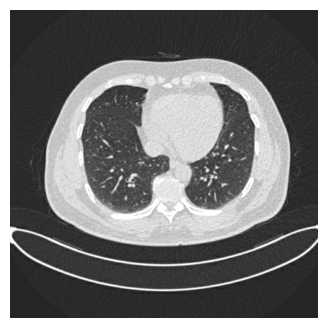

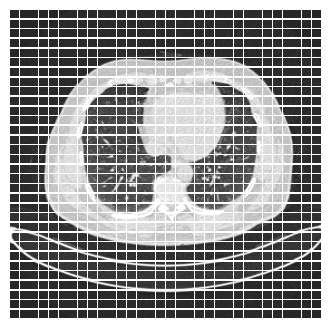

In [11]:
# display patches for a sample image
plt.figure(figsize=(4, 4))
image = x_train[0].numpy()
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [12]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=(image_size, image_size, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# THE FIX HERE IS TO CONVERT THE IMAGES INTO SINGLE CHANNEL

In [14]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

ValueError: in user code:

    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1028, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1122, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 691, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/vasu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 962, in sparse_categorical_matches  **
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 3 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](IteratorGetNext:1)' with input shapes: [?,3].
